## Ejercicio 10

El conjunto de datos **“Fingers”** consiste en una serie de imágenes de 64x64 píxeles con fondo negro donde en su centro se encuentra un mano que muestra una cantidad de dedos que va desde 0 a 5. La versión original de este conjunto de imágenes se encuentra en: https://www.kaggle.com/koryakinp/fingers  

<div style="text-align: center;">
    <img src='/../imagenes/p4-ej10.png' width="40%">
</div>

Muchas veces se utilizan técnicas de procesamiento de imágenes para obtener características representativas (features extraction) de los objetos dentro de una imagen con el objetivo de simplificar el problema, reducir la dimensionalidad y/o reducir el costo de procesamiento. Bibliotecas como **OpenCV** o **SciKit-Learn** proveen funciones que permiten procesar imágenes y obtener valores estadísticos que caracterizan los objetos.


### a)

Utilice la función **regionprops** de **SciKitLearn** con algunas imágenes de ejemplo del dataset para  experimentar con las distintas características que extrae de la imagen de la mano.  

Área: 3740.0
Perímetro: 343.49747468305833
Excentricidad: 0.05970895058121077
Solidez: 0.9130859375
Bounding box: (0, 0, 64, 64)
Centroide: (np.float64(31.470320855614972), np.float64(31.55133689839572))
----------------------------------------
Área: 34.0
Perímetro: 23.485281374238568
Excentricidad: 0.9413057228483238
Solidez: 0.723404255319149
Bounding box: (30, 26, 36, 38)
Centroide: (np.float64(32.529411764705884), np.float64(31.058823529411764))
----------------------------------------


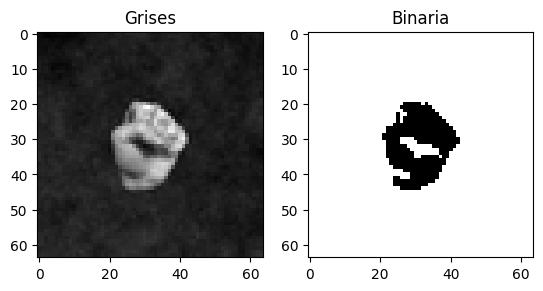

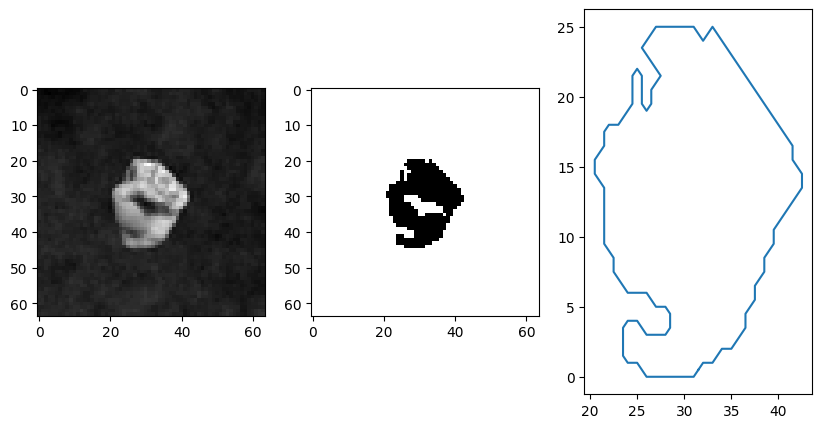

In [25]:
FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR   = '../imagenes/Fingers/' # carpeta donde se encuentran los datasets
import os, glob, math, warnings
import pandas as pd
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import closing, footprint_rectangle
from skimage.segmentation import clear_border
from skimage.measure import regionprops, label
img = io.imread(DATOS_DIR + "samples/0L.png")
# Si la imagen tiene 4 canales (RGBA), convertir a RGB antes de pasar a escala de grises
if img.shape[-1] == 4:
    img_rgb = img[..., :3]
    gray = color.rgb2gray(img_rgb)
else:
    gray = color.rgb2gray(img) if len(img.shape) == 3 else img

# binarización (umbral automático Otsu)
thresh = threshold_otsu(gray)
binary = gray < thresh  # mano en blanco (1), fondo negro (0)

# etiquetar regiones
label_img = label(binary)

# extraer propiedades
props = regionprops(label_img)

# mostrar algunas propiedades de la primera región
for prop in props:
    print(f"Área: {prop.area}")
    print(f"Perímetro: {prop.perimeter}")
    print(f"Excentricidad: {prop.eccentricity}")
    print(f"Solidez: {prop.solidity}")
    print(f"Bounding box: {prop.bbox}")
    print(f"Centroide: {prop.centroid}")
    print("-" * 40)

#graficar
plt.subplot(1,2,1)
plt.imshow(gray, cmap="gray")
plt.title("Grises")

plt.subplot(1,2,2)
plt.imshow(binary, cmap="gray")
plt.title("Binaria")
plt.show()

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(gray, cmap='gray')
axs[1].imshow(binary, cmap='gray')

contour = find_contours(binary, 0.5)[0]
y, x = contour.T

axs[2].plot(x, y.max()-y)



### b)

Implemente un script que convierta las imágenes en las carpetas **“test”** y **“train”** del dataset **“Fingers”** en dos archivos (uno por carpeta) separados por comas (csv). De todas las características que provee **regionprops**, tienen potencial aquellas que son independientes o se pueden independizar de las unidades (píxeles). Algunas de estas características pueden ser:  

- **filled_area:** cantidad de píxeles que contiene región (podría interpretarse como píxeles cuadrados).
- **major_axis_length:** longitud (en píxeles) del eje mayor de la elipse que mejor se ajusta a la región.
- **minor_axis_length:** longitud (en píxeles) del eje menor de la elipse que mejor se ajusta a la región.
- **perimeter:** cantidad de píxeles que forman el contorne de la región.
- **eccentricity:** excentricidad de la elipse de mejor ajuste, cerca de 0 es un círculo, mientras que cerca de 1 es una elipse más “larga”.
- **solidity:** razón entre la cantidad de píxeles de la región original y de la región convexa. Para generar una región convexa se completan los pixeles de forma de eliminar regiones cóncavas de una figura. La región convexa de una estrella de 5 puntas se convertirá en un pentágono al completarla.
- **extent:** razón entre pixeles de la región original y el rectángulo que la contiene (bounding box).


In [24]:
import os, glob, math, warnings
import pandas as pd
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import closing, footprint_rectangle
from skimage.segmentation import clear_border
from skimage.measure import regionprops, label

warnings.filterwarnings("ignore", category=FutureWarning)  # silencia warnings molestos

from skimage.morphology import footprint_rectangle

def extraer_caracteristicas(imagen):
    umbral = threshold_otsu(imagen)
    imagen_bn = (imagen > umbral)*1
    imagen_bn = closing(imagen_bn, footprint_rectangle((3, 3)))  # ✅ FIX definitivo
    imagen_lista = clear_border(imagen_bn)
    regiones = regionprops(label(imagen_lista))
    return (regiones[0], imagen_lista)


def convertir_dataset(dir_orig, dir_arch_dest):
    columnas = ['AreaNorm', 'PerimNorm', 'RazonEjes', 'Excentricidad', 
                'Solidez', 'Extension', 'CantDedos']

    archivos = glob.glob(os.path.join(dir_orig, '**/*.png'), recursive=True)
    data = []

    total = len(archivos)
    for nro, archivo in enumerate(archivos, start=1):
        if nro % 200 == 0 or nro == total:  # imprime cada 200 imgs, no en todas
            print(f"\rProcesando {nro}/{total} imágenes ({100*nro/total:.2f}%)", end="")

        imagen = io.imread(archivo)
        cant_dedos = int(os.path.basename(os.path.dirname(archivo)))  # nombre carpeta = etiqueta

        props, imagen_bn = extraer_caracteristicas(imagen)

        area = props.filled_area
        ej_mayor = props.major_axis_length
        ej_menor = props.minor_axis_length
        perim = props.perimeter
        excentr = props.eccentricity
        solidez = props.solidity
        extension = props.extent

        # normalización
        area = area / (ej_mayor * ej_menor)
        perim = perim / math.sqrt(ej_mayor * ej_menor)
        razon_ej = ej_menor / ej_mayor

        data.append([area, perim, razon_ej, excentr, solidez, extension, cant_dedos])

    df = pd.DataFrame(columns=columnas, data=data)
    df.to_csv(dir_arch_dest, index=False)
    print(f"\n✅ Guardado en {dir_arch_dest}")

# Uso -> guarda en DeepLearning/Data_Sets/p4/
base_out = "../Data_Sets/p4/"

convertir_dataset("../imagenes/Fingers/train", os.path.join(base_out, "fingers_train.csv"))
convertir_dataset("../imagenes/Fingers/test",  os.path.join(base_out, "fingers_test.csv"))


Procesando 17999/17999 imágenes (100.00%)
✅ Guardado en ../Data_Sets/p4/fingers_train.csv
Procesando 3600/3600 imágenes (100.00%)
✅ Guardado en ../Data_Sets/p4/fingers_test.csv


### c)

Entrene un modelo de multiperceptrón a partir del archivo de entrenamiento generado en el punto anterior.  


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics, model_selection

from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import seaborn as sns
DATOS_DIR   = '../Data_Sets/p4/' # carpeta donde se encuentran los datasets
# %% CARGA DE DATASET
nom_archivo = DATOS_DIR + 'fingers_train.csv'
datos = pd.read_csv(nom_archivo)


# separa características y clase
X = np.array(datos.iloc[:, :-1])
Y = np.array(datos.iloc[:, -1])
nomClases = datos.iloc[:, -1].value_counts()

# Target codificado como one-hot
encoder = preprocessing.LabelEncoder()
Y_nro = encoder.fit_transform(Y)
Y_bin= to_categorical(Y_nro)

# %% --- CONJUNTOS DE ENTRENAMIENTO Y VALIDACION ---
X_train, X_val, Y_train, Y_val = model_selection.train_test_split( \
                                         X, Y_bin, test_size=0.20) #, random_state=42)

normalizador = preprocessing.StandardScaler()
X_train = normalizador.fit_transform(X_train)
X_val = normalizador.transform(X_val)

datos

,AreaNorm,PerimNorm,RazonEjes,Excentricidad,Solidez,Extension,CantDedos
0,0.556303,5.794764,0.722026,0.691866,0.619767,0.414141,4
1,0.583037,5.736377,0.677103,0.735888,0.630769,0.451613,4
2,0.607753,5.582839,0.585364,0.810771,0.665789,0.443860,4
3,0.593257,5.720481,0.649227,0.760595,0.647651,0.430804,4
4,0.580961,5.607433,0.695218,0.718799,0.646154,0.437500,4
...,...,...,...,...,...,...,...
17994,0.655458,4.687145,0.482004,0.876169,0.756494,0.663818,2
17995,0.619583,4.979995,0.507875,0.861431,0.695324,0.548810,2
17996,0.618300,4.930223,0.465299,0.885153,0.700311,0.563750,2
17997,0.566010,4.606163,0.528035,0.849223,0.633880,0.495726,2


In [27]:
ENTRADAS = X_train.shape[1]
SALIDAS = Y_train.shape[1]
OCULTAS = 8
EPOCAS = 200
LOTES = 32
PACIENCIA = 5
ACTIVACION = 'tanh'
OPTIMIZADOR = 'adam'


# %% CONSTRUCCION DEL MODELO
model = Sequential()
model.add(Dense(OCULTAS, input_shape=[ENTRADAS], activation=ACTIVACION))
model.add(Dense(SALIDAS, activation='softmax'))
model.summary()  #-- muestra la cantidad de parámetros de la red


model.compile(optimizer=OPTIMIZADOR, loss='categorical_crossentropy', metrics=['accuracy'])

# %% ENTRENAMIENTO

# parada temprana para evitar el sobreajuste
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# entrena el modelo y guarda la historira del progreso
history = model.fit(X_train,Y_train, epochs=EPOCAS, batch_size=LOTES, validation_data = (X_val, Y_val), callbacks=[early_stop])

/home/manuel/Documents/Facultad/DeepLearning/env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-03 12:40:57.183671: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110 (440.00 B)

 Trainable params: 110 (440.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4925 - loss: 1.3935 - val_accuracy: 0.7508 - val_loss: 0.8926
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8058 - loss: 0.7126 - val_accuracy: 0.8428 - val_loss: 0.5787
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8828 - loss: 0.4864 - val_accuracy: 0.9108 - val_loss: 0.4104
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9333 - loss: 0.3531 - val_accuracy: 0.9472 - val_loss: 0.3047
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9521 - loss: 0.2698 - val_accuracy: 0.9539 - val_loss: 0.2413
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9575 - loss: 0.2176 - val_accuracy: 0.9575 - val_loss: 0.1990
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9615 - loss: 0.1834 - val_accuracy: 0.9614 - val_loss: 0.1710
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.9640 - loss: 0.1590 - val_ac

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_train : 99.153%
Reporte de métricas de entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2367
           1       0.99      0.99      0.99      2436
           2       0.97      0.98      0.98      2421
           3       0.99      0.98      0.98      2365
           4       1.00      1.00      1.00      2415
           5       1.00      1.00      1.00      2395

    accuracy                           0.99     14399
   macro avg       0.99      0.99      0.99     14399
weighted avg       0.99      0.99      0.99     14399

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_val : 99.083%
Reporte de métricas de validación:
              precision    recall  f1-score   su

<Axes: >

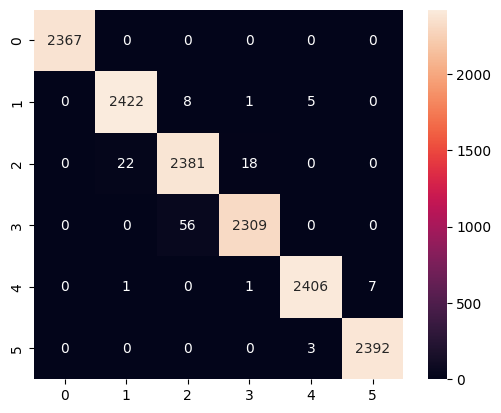

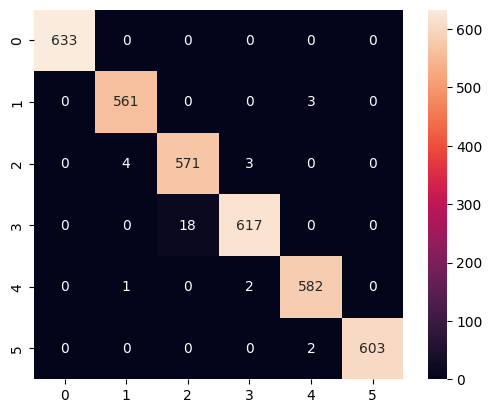

In [28]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- "conversión a entero"

Y_true = np.argmax(Y_train,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_train : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de entrenamiento:\n%s" % report)
cm = metrics.confusion_matrix(Y_true, Y_pred_nro)

plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

# %% --- VALIDACION ---
Y_pred = model.predict(X_val)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- conversión a entero

Y_true = np.argmax(Y_val,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_val : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de validación:\n%s" % report)

cm = metrics.confusion_matrix(Y_true, Y_pred_nro)
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

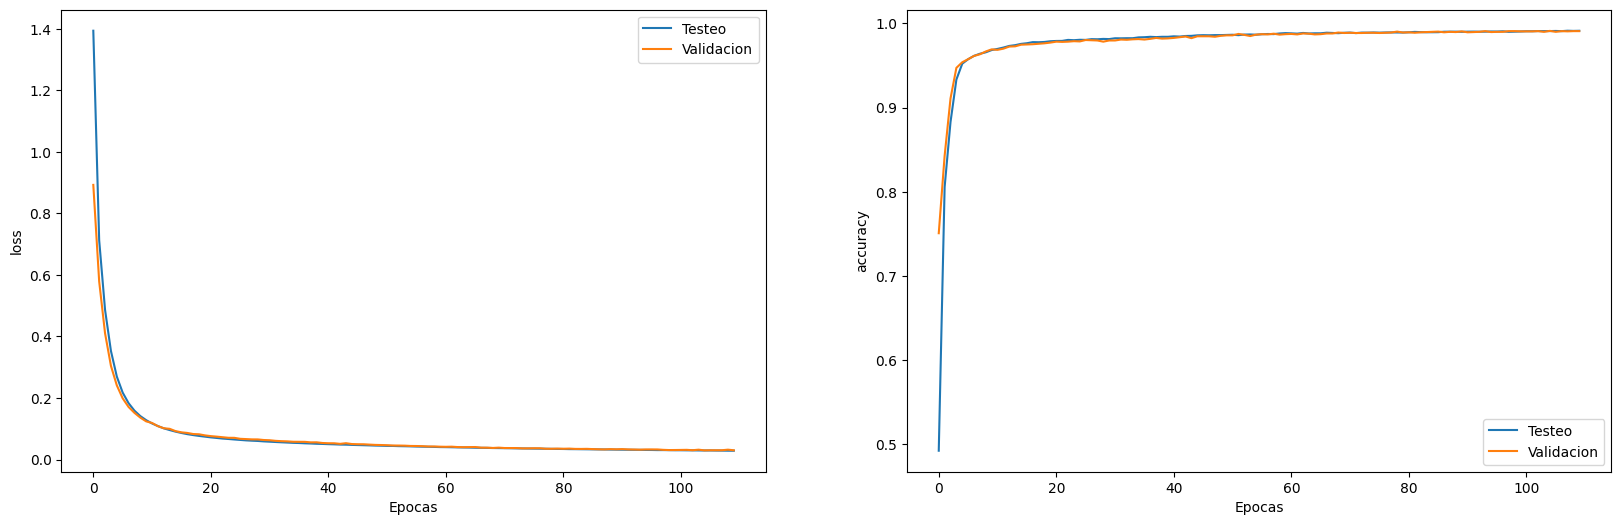

In [29]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'loss', history.epoch, hist)
dibujar_curva(axs[1], 'accuracy', history.epoch, hist)


### d)

Reflexione acerca de las propiedades geométricas generadas a partir de un objeto/región de una imagen. ¿Cómo cree que afectaría la rotación, translación y escalado de un objeto/región dentro de la imagen?  

**Traslación** afecta propiedades posicionales,

**Rotación** afecta orientación y bounding box,

**Escalado** afecta medidas absolutas.

Por eso, en visión artificial se suelen preferir descriptores invariantes a estas transformaciones (momentos invariantes, razones, histogramas de gradientes, etc.), ya que representan la forma sin depender de la posición, orientación o tamaño.